**RDS (DS-UA 202) Spring 2022: Homework 2 Template**

This notebook is a template for problem 3. You should save a copy of this notebook and write your code in that copy. The code to setup the analysis is provided for you here. You should not edit or add to the setup code.

Some suggested steps are included as comments in the below code cells. You do not need to follow these (other reasonable solutions or approaches are acceptable).

# Setup

Make sure you run all cells in the setup section. Do not modify any code in this section.

In [1]:
!pip install DataSynthesizer

In [2]:
from DataSynthesizer.DataDescriber import DataDescriber
from DataSynthesizer.DataGenerator import DataGenerator
from DataSynthesizer.ModelInspector import ModelInspector
from DataSynthesizer.lib.utils import normalize_given_distribution, read_json_file, pairwise_attributes_mutual_information, mutual_information, set_random_seed

from IPython.display import clear_output
from scipy.stats import entropy, ks_2samp
from scipy.spatial.distance import euclidean
from sklearn.metrics import mutual_info_score
from random import randint
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
def generate_data_A(input_data_file, output_data_size, seed=None):
    seed = seed or randint(0, 2**30)
    description_file = description_files['A']
    
    describer = DataDescriber()
    describer.describe_dataset_in_random_mode(input_data_file, seed=seed)
    describer.save_dataset_description_to_file(description_file)
    
    generator = DataGenerator()
    generator.generate_dataset_in_random_mode(output_data_size, description_file, seed=seed)
    return generator.synthetic_dataset

In [4]:
def generate_data_B(input_data_file, output_data_size, epsilon=0.1, seed=None):
    seed = seed or randint(0, 2**30)
    description_file = description_files['B']
    
    describer = DataDescriber()
    describer.describe_dataset_in_independent_attribute_mode(input_data_file, epsilon=epsilon, seed=seed)
    describer.save_dataset_description_to_file(description_file)
    
    generator = DataGenerator()
    generator.generate_dataset_in_independent_mode(output_data_size, description_file, seed=seed)
    return generator.synthetic_dataset

In [5]:
def generate_data_CD(input_data_file, output_data_size, description_file, epsilon=0.5, k=1, seed=None):
    seed = seed or randint(0, 2**30)
    
    describer = DataDescriber()
    describer.describe_dataset_in_correlated_attribute_mode(input_data_file, k=k, epsilon=epsilon, seed=seed)
    describer.save_dataset_description_to_file(description_file)
    
    generator = DataGenerator()
    generator.generate_dataset_in_correlated_attribute_mode(output_data_size, description_file, seed=seed)
    return generator.synthetic_dataset

def generate_data_C(input_data_file, output_data_size, epsilon=0.1, seed=None):
    return generate_data_CD(input_data_file, output_data_size, description_files['C'], epsilon, k=1, seed=seed)

def generate_data_D(input_data_file, output_data_size, epsilon=0.1, seed=None):
    return generate_data_CD(input_data_file, output_data_size, description_files['D'], epsilon, k=2, seed=seed)

Start with a real dataset __hw_compas__ and a fake dataset __hw_fake__. Generate synthetic datasets of size __N=10000__, in the following four categories:
- A:  random mode
- B: independent attribute mode with __epsilon = 0.1__
- C:  correlated attribute mode with __epsilon = 0.1__, Bayes net degree k=1
- D: correlated attribute mode with __epsilon = 0.1__, Bayes net degree k=2

In [6]:
# Packages for reading csv file into Colaboratory:
!pip install -U -q PyDrive==1.3.1

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client. 
# Please follow the steps as instructed when you run the following commands. 

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [7]:
fileid_compas = '1kgSIBkOM9y0nz_l8LI8ze9TAhF5gbb64'    
real_data_file = 'hw_compas.csv'

fileid_fake = '1b_T0SHQUMbVvZueZ6yXlxTKBHctMgM0k'    
fake_data_file = 'hw_fake.csv'

downloaded = drive.CreateFile({'id':fileid_compas}) 
downloaded.GetContentFile(real_data_file)  
df_real = pd.read_csv(real_data_file)

downloaded = drive.CreateFile({'id':fileid_fake}) 
downloaded.GetContentFile(fake_data_file)  
df_fake = pd.read_csv(fake_data_file)

In [8]:
output_data_size = 10000
epsilon = 0.1

seed = 0  # make the entire notebook reproducible

description_files = {'A': './descrption_A.json', 
                     'B': './descrption_B.json', 
                     'C': './descrption_C.json', 
                     'D': './descrption_D.json'}

set_random_seed(seed)

df_real_A = generate_data_A(real_data_file, output_data_size)
df_real_B = generate_data_B(real_data_file, output_data_size, epsilon=epsilon)
df_real_C = generate_data_C(real_data_file, output_data_size, epsilon=epsilon)
df_real_D = generate_data_D(real_data_file, output_data_size, epsilon=epsilon)

df_fake_A = generate_data_A(fake_data_file, output_data_size)
df_fake_B = generate_data_B(fake_data_file, output_data_size, epsilon=epsilon)
df_fake_C = generate_data_C(fake_data_file, output_data_size, epsilon=epsilon)
df_fake_D = generate_data_D(fake_data_file, output_data_size, epsilon=epsilon)

clear_output()

# Part (a)

## Q1

Calculate the Median, Mean, Min, Max of __age__ and __score__ for each A, B, C and D. Compare to the ground truth values in __hw_compas__, present results in a table.

In [9]:
# Your code here
# df_real_A.shape
def table_describe(df):
  summ = df.drop(columns=['sex','race'])
  summary = pd.DataFrame(summ.dtypes,columns=['dytpes'])
  summary = summary.reset_index()
  summary = summary.rename(columns={'index':'Name'})
  summary['Median'] = summ.median().values
  summary['Mean'] = summ.mean().values
  summary['Min'] = summ.min().values
  summary['Max'] = summ.max().values

  return summary
print("df_real")
print(table_describe(df_real))
print('-----------------------')
print("df_real_A:")
print(table_describe(df_real_A))
print('-----------------------')
print("df_real_B:")
print(table_describe(df_real_B))
print('-----------------------')
print("df_real_C:")
print(table_describe(df_real_C))
print('-----------------------')
print("df_real_D:")
print(table_describe(df_real_D))

df_real
    Name dytpes  Median       Mean  Min  Max
0    age  int64    32.0  35.143319   18   96
1  score  int64     4.0   4.371268   -1   10
-----------------------
df_real_A:
    Name dytpes  Median     Mean  Min  Max
0    age  int64    51.0  50.1731    0  100
1  score  int64     5.0   4.9392   -1   10
-----------------------
df_real_B:
    Name   dytpes  Median     Mean   Min   Max
0    age  float64    33.0  35.7354  18.0  76.0
1  score    int64     4.0   4.3657   1.0  10.0
-----------------------
df_real_C:
    Name   dytpes  Median     Mean   Min   Max
0    age  float64    36.0  41.5788  18.0  96.0
1  score    int64     5.0   4.9487  -1.0  10.0
-----------------------
df_real_D:
    Name   dytpes  Median     Mean   Min   Max
0    age  float64    39.0  44.1532  18.0  96.0
1  score    int64     4.0   4.4660  -1.0  10.0


## Q2

Plot histograms of the age attribute in hw_compas and in synthetic datasets generated under settings A and B.

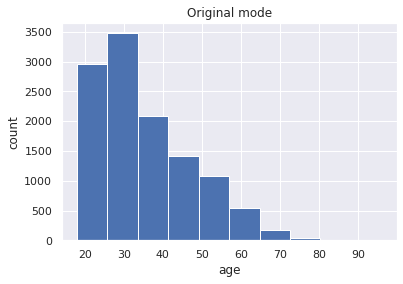

In [15]:
df_real['age'].hist()
plt.xlabel('age')
plt.ylabel('count')
plt.title("Original mode")
plt.show()


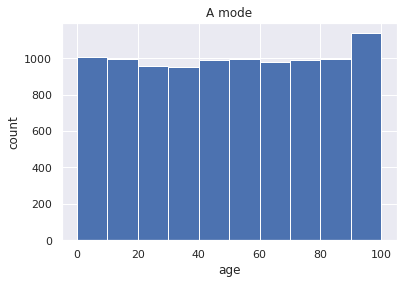

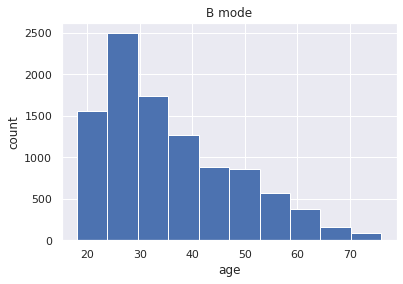

In [11]:
# Your code here
df_real_A['age'].hist()
plt.xlabel('age')
plt.ylabel('count')
plt.title("A mode")
plt.show()

df_real_B['age'].hist()
plt.title('B mode')
plt.xlabel('age')
plt.ylabel('count')
plt.show()

Create bar plots for the sex attribute in hw_compas and in synthetic datasets generated under settings A and B.

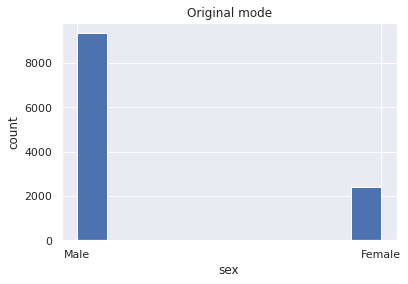

In [14]:
df_real['sex'].hist()
plt.xlabel('sex')
plt.ylabel('count')
plt.title("Original mode")
plt.show()


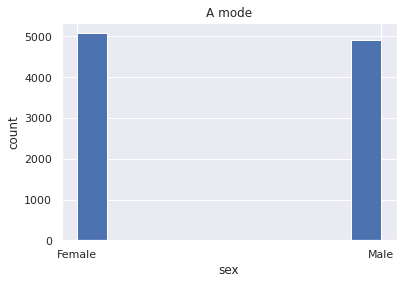

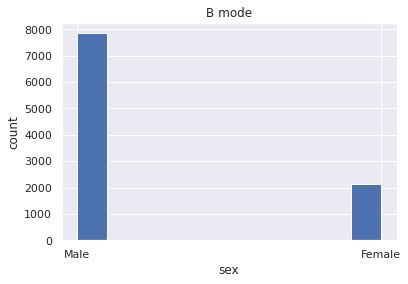

In [12]:
# Your code here
df_real_A['sex'].hist()
plt.xlabel('sex')
plt.title('A mode')
plt.ylabel('count')
plt.show()

df_real_B['sex'].hist()
plt.xlabel('sex')
plt.ylabel('count')
plt.title('B mode')
plt.show()


The functions below can be used to compute two statistical measures: __Two-sample Kolmogorov–Smirnov test__ and __KL-divergence__.

### Two-sample Kolmogorov–Smirnov test for continuous attributes

Use the `ks_test` function to run the Kolomogorov-Smirnov test on the age attribute. You should first test `df_real` against `df_real_A` and then test `df_real` against `df_real_B`.

In [16]:
def ks_test(df_in: pd.DataFrame, df_out: pd.DataFrame, attr: str):
    """
    df_in: the sensitive dataset
    df_out: the synthetic dataset
    attr: the attribute that will be calculated for Two-sample Kolmogorov–Smirnov test
    """
    return ks_2samp(df_in[attr], df_out[attr])[0]

In [17]:
# Your code here
ks_test(df_real,df_real_A,'age')

0.3735091775112699

In [18]:
ks_test(df_real,df_real_B,'age')

0.026252445351705345

### KL-divergence for categorical attributes

Use the `kl_test` function to calculate the KL-divergence on the sex attribute. You should first run `df_real` against `df_real_A` and then run `df_real` against `df_real_B`.

In [19]:
def get_distribution_of_categorical_attribute(attribute: pd.Series, indicies=None):
    distribution = attribute.dropna().value_counts()
    # distribution = attribute.value_counts()
    if indicies is not None:
        for idx in set(indicies) - set(distribution.index):
            distribution.loc[idx] = 0
        for inx in set(distribution.index) - set(indicies):
            # index1 = distribution.loc[inx]
            # print(index1)
            del distribution[inx]
    distribution.sort_index(inplace=True)
    return distribution

def kl_test(df_in: pd.DataFrame, df_out: pd.DataFrame, attr: str):
    """
    df_in: the sensitive dataset
    df_out: the synthetic dataset
    attr: the attribute that will be calculated for KL-divergence.
    """
    # print(df_out)
    distribution_in = get_distribution_of_categorical_attribute(df_in[attr])/len(df_in)
    distribution_out = get_distribution_of_categorical_attribute(df_out[attr], distribution_in.index)/len(df_out)
    # print(distribution_in)
    # print(distribution_out)
    # print(len(df_out))
    return entropy(distribution_out, distribution_in)

In [20]:
kl_test(df_real,df_real_A,'sex')

0.22319792405369002

In [21]:
kl_test(df_real,df_real_B,'sex')

0.0002494300869420041

## Q3

Calculate the pairwise mutual information matrix for `hw_fake`, `df_fake_C`, and `df_fake_D`.

In [22]:
# Use pairwise_attributes_mutual_information function
# For function parameters, refer to https://github.com/DataResponsibly/DataSynthesizer/blob/master/DataSynthesizer/lib/utils.py#L31

# Your code here
df_fake_map = pairwise_attributes_mutual_information(df_fake)
df_fake_C_map = pairwise_attributes_mutual_information(df_fake_C)
df_fake_D_map = pairwise_attributes_mutual_information(df_fake_D)

Plot each pairwise mutual information matrix below using `sns.heatmap`. You should set `vmax=1` and `vmin=0` in your call to `sns.heatmap`.

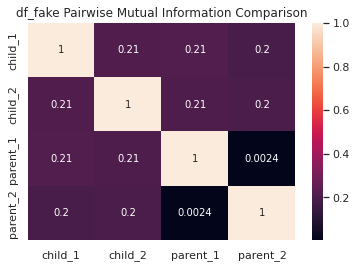

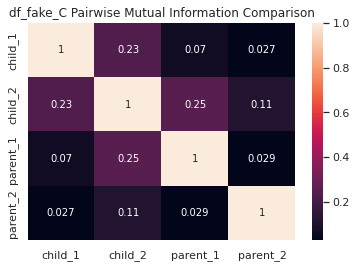

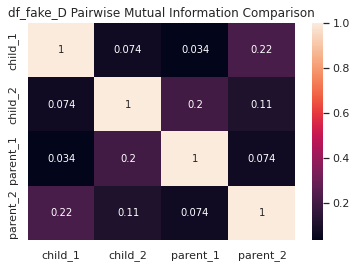

In [23]:
# Use can sns.heatmap for pairwise mutual information
# For examples, refer to https://seaborn.pydata.org/generated/seaborn.heatmap.html

# Your code here
sns.heatmap(df_fake_map,annot= True)
plt.title("df_fake Pairwise Mutual Information Comparison")
plt.show()
plt.title("df_fake_C Pairwise Mutual Information Comparison")
sns.heatmap(df_fake_C_map,annot= True)
plt.show()
plt.title("df_fake_D Pairwise Mutual Information Comparison")
sns.heatmap(df_fake_D_map,annot= True)
plt.show()

# Part (b)

With epsilon = 0.1, generate __10__ synthetic datasets for each of mode A, B, and C by specifying different seeds. Calculate the mean and median in each dataset. We recommend using a for loop here, e.g. `for rep in range(10):`

In [24]:
set_random_seed(seed) # this will specify different seeds
df_real_As = []
df_real_Bs = []
df_real_Cs = []
for rep in range(10):
  # Your code here
  df_real_As.append(generate_data_A(real_data_file, output_data_size))
  df_real_Bs.append(generate_data_B(real_data_file, output_data_size, epsilon=epsilon))
  df_real_Cs.append(generate_data_C(real_data_file, output_data_size, epsilon=epsilon))

clear_output()

In [25]:
kl_test(df_real,df_real_As[3],'race')

1.1981752907888281

In [26]:
df_real_As[0]['age'].mean()


summary = pd.DataFrame(columns=['model','age_mean','age_median'])
for i in range(10):
  summary.loc[i,'model'] = 'A'
  summary.loc[i,'age_mean'] = df_real_As[i]['age'].mean()
  summary.loc[i,'age_median'] = df_real_As[i]['age'].median()

for i in range(10):
  summary.loc[i+10,'model'] = 'B'
  summary.loc[i+10,'age_mean'] = df_real_Bs[i]['age'].mean()
  summary.loc[i+10,'age_median'] = df_real_Bs[i]['age'].median()

for i in range(10):
  summary.loc[i+20,'model'] = 'C'
  summary.loc[i+20,'age_mean'] = df_real_Cs[i]['age'].mean()
  summary.loc[i+20,'age_median'] = df_real_Cs[i]['age'].median()

summary

model age_mean age_median
0      A  50.1731       51.0
1      A  49.8201       49.0
2      A   50.638       51.0
3      A  50.1614       50.0
4      A  50.1171       50.0
5      A  49.8993       50.0
6      A  49.5898       50.0
7      A  50.3284       51.0
8      A  49.7227       49.0
9      A  49.9459       50.0
10     B  35.7354       33.0
11     B  36.9584       33.0
12     B  36.0901       33.0
13     B  36.3214       33.0
14     B  36.4302       33.0
15     B  34.8719       31.0
16     B  37.0742       32.0
17     B  36.5627       32.0
18     B  36.1204       32.0
19     B  35.5626       32.0
20     C  41.5788       36.0
21     C   44.039       38.0
22     C   40.037       35.0
23     C   41.676       36.0
24     C   40.071       35.0
25     C  42.9967       36.0
26     C  36.1286       32.0
27     C  43.7623       39.0
28     C  40.7417       35.0
29     C  43.5333       36.0

Plot the mean and the median values as box-and-whiskers plots. You should have two plots: one for the mean and one for the median. Put the mode (A, B, C) on the x-axis. The median/mean should be on the y-axis.

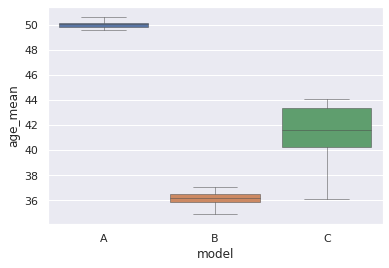

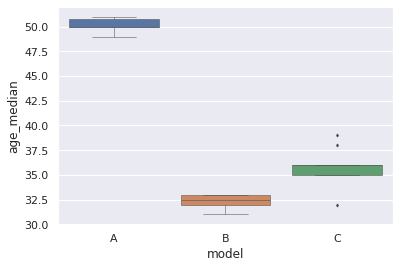

In [27]:
# You can use sns.boxplot for the plots
# For examples, refer to https://seaborn.pydata.org/generated/seaborn.boxplot.html

# Your code here
sns.boxplot(x='model',y='age_mean',data=summary,linewidth=0.5,fliersize=2)
plt.show()

sns.boxplot(x='model',y='age_median',data=summary,linewidth=0.5,fliersize=2)
plt.show()

# Part (c)

Study how the KL-divergence of the race attribute changes for settings B, C, and D as you vary your privacy budget __epsilon__ = [0.02, 0.04, ... , 0.1]. For each setting B, C, D, you should generate 10 synthetic data sets for each epsilon value (a total of 3 * 10 * 6 = 180 datasets). 

Hint: We recommend using a nested for loop and have provided some starter code in the cell below. You may use a different approach as you see fit.

In [28]:
# generate the datasets and calculate KL-divergence in this cell
set_random_seed(seed)
epsilons = [0.02, 0.04, 0.06, 0.08, 0.1]
repeat = 10
df_real_B2=[]
df_real_C2=[]
df_real_D2=[]
for i, epsilon in enumerate(epsilons):
    print(f'~~~ i={i}, epsilon={epsilon} ~~~')
    for rep in range(repeat):
      # Your code here
      df_real_B2.append(generate_data_B(real_data_file, output_data_size, epsilon=epsilon))
      df_real_C2.append(generate_data_C(real_data_file, output_data_size, epsilon=epsilon))
      df_real_D2.append(generate_data_D(real_data_file, output_data_size, epsilon=epsilon))

clear_output()

Create the box-and-whisker plots in the cell below.

In [ ]:
sum1 = pd.DataFrame(columns=['model','kl','eplison'])

for i in range(50):
  sum1.loc[i,'model'] = 'B'
  sum1.loc[i,'kl'] = kl_test(df_real,df_real_B2[i],'race')

for i in range(10):
  sum1.loc[i,'eplison']=0.02

for i in range(10):
  sum1.loc[i+10,'eplison']=0.04

for i in range(10):
  sum1.loc[i+20,'eplison']=0.06

for i in range(10):
  sum1.loc[i+30,'eplison']=0.08

for i in range(10):
  sum1.loc[i+40,'eplison']=0.1
sum1

(0.0, 0.25)

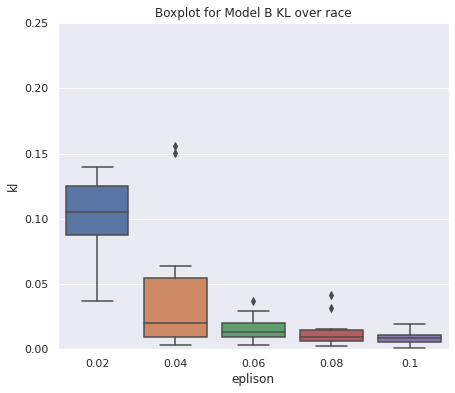

In [84]:
plt.figure(figsize=(7,6))
sns.boxplot(x='eplison',y='kl',data=sum1)
plt.title("Boxplot for Model B KL over race")
plt.ylim(0,0.25)

In [ ]:
sum2 = pd.DataFrame(columns=['model','kl','eplison'])

for i in range(50):
  sum2.loc[i,'model'] = 'C'
  sum2.loc[i,'kl'] = kl_test(df_real,df_real_C2[i],'race')

for i in range(10):
  sum2.loc[i,'eplison']=0.02

for i in range(10):
  sum2.loc[i+10,'eplison']=0.04

for i in range(10):
  sum2.loc[i+20,'eplison']=0.06

for i in range(10):
  sum2.loc[i+30,'eplison']=0.08

for i in range(10):
  sum2.loc[i+40,'eplison']=0.1
sum2

(0.0, 0.8)

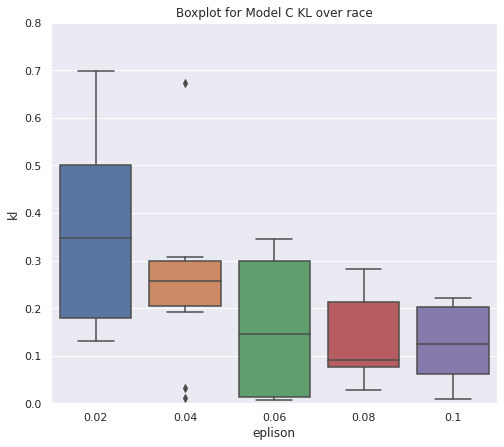

In [80]:
plt.figure(figsize=(8,7))
sns.boxplot(x='eplison',y='kl',data=sum2)
plt.title("Boxplot for Model C KL over race")
plt.ylim(0,0.8)

In [ ]:
sum3 = pd.DataFrame(columns=['model','kl','eplison'])

for i in range(50):
  sum3.loc[i,'model'] = 'D'
  sum3.loc[i,'kl'] = kl_test(df_real,df_real_D2[i],'race')

for i in range(10):
  sum3.loc[i,'eplison']=0.02

for i in range(10):
  sum3.loc[i+10,'eplison']=0.04

for i in range(10):
  sum3.loc[i+20,'eplison']=0.06

for i in range(10):
  sum3.loc[i+30,'eplison']=0.08

for i in range(10):
  sum3.loc[i+40,'eplison']=0.1
sum3

Text(0.5, 1.0, 'Boxplot for Model D KL over race')

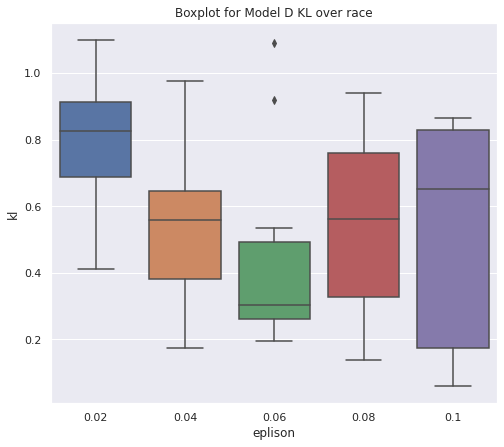

In [71]:
plt.figure(figsize=(8,7))
sns.boxplot(x='eplison',y='kl',data=sum3)
plt.title("Boxplot for Model D KL over race")
# plt.ylim(0,0.8)

In [ ]:
# Your code here
# kl_test(df_real,df_real_C2[0],'race')
# kl_test(df_fake,df_fake_A,'child_1')

sum = pd.DataFrame(columns=['model','kl'])
for i in range(50):
  sum.loc[i,'model'] = 'B'
  sum.loc[i,'kl'] = kl_test(df_real,df_real_B2[i],'race')

for i in range(50):
  sum.loc[i+50,'model'] = 'C'
  sum.loc[i+50,'kl'] = kl_test(df_real,df_real_C2[i],'race')

for i in range(50):
  sum.loc[i+100,'model'] = 'D'
  sum.loc[i+100,'kl'] = kl_test(df_real,df_real_D2[i],'race')
  

sum.head(20)
# sum.tail(20)

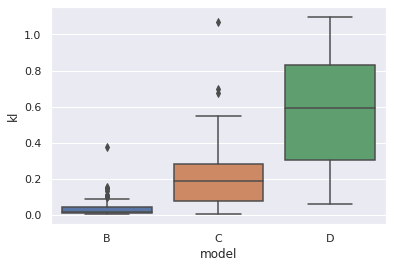

In [ ]:
sns.boxplot(x='model',y='kl',data=sum)